# L-BF-IS for a 8-dimensional borehole problem 
source: https://www.sfu.ca/~ssurjano/borehole.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models import NN, train_NN
from tqdm.notebook import tqdm
import torch

Firstly, we introduce the LF/HF evaluation functions and origin probability distribution $p(\xi)$.

In [2]:
def transform_xi(xi): # transform xi into correct range
    if xi.ndim != 2 or len(xi[0]) != 8:
        raise ValueError('Incorrect xi structure.')
    new_xi = torch.zeros_like(xi)
    new_xi[:,0] = 0.10 + 0.0161812 * xi[:,0]
    new_xi[:,1] = (7.71 + 1.0056 * xi[:,1]).exp()
    new_xi[:,2] = (115600 - 63070) * xi[:,2] + 63070
    new_xi[:,3] = (1110 - 990) * xi[:,3] + 990
    new_xi[:,4] = (116 - 63.1) * xi[:,4] + 63.1
    new_xi[:,5] = (820 - 700) * xi[:,5] + 700
    new_xi[:,6] = (1680 - 1120) * xi[:,6] + 1120
    new_xi[:,7] = (12045 - 9855) * xi[:,7] + 9855
    return new_xi

def x_L(xi):
    xi = transform_xi(xi)

    lnrrw  = torch.log(xi[:,1]/xi[:,0])
    top    = 2 * np.pi * xi[:,2] * (xi[:,3] - xi[:, 5])
    bottom = lnrrw * (1 + 2 * xi[:,6] * xi[:,2]/(lnrrw * xi[:,0] * xi[:,7]) + xi[:,2]/xi[:,4])
    return top/bottom

def x_H(xi):
    xi = transform_xi(xi)

    lnrrw  = torch.log(xi[:,1]/xi[:,0])
    top    = 5 * xi[:,2] * (xi[:,3] - xi[:, 5])
    bottom = lnrrw * (1.5 + 2 * xi[:,6] * xi[:,2]/(lnrrw * xi[:,0] * xi[:,7]) + xi[:,2]/xi[:,4])
    return top/bottom

def sample_xi_p(N):
    return torch.hstack((torch.randn(N, 2),torch.rand(N,6)))

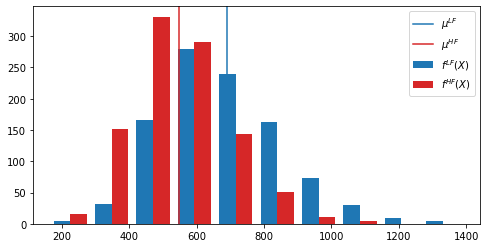

In [6]:
xi = sample_xi_p(1000)

xL = x_L(xi)
xH = x_H(xi)

plt.figure(figsize=(8,4))
plt.hist([xL,xH],label=[r'$f^{LF}(X)$',r'$f^{HF}(X)$'],color=['tab:blue','tab:red'])
plt.axvline(x = ExL, color = 'tab:blue', label = r'$\mu^{LF}$')
plt.axvline(x = ExH, color = 'tab:red', label = r'$\mu^{HF}$')
plt.legend()
plt.savefig('dim-8-BFdata.png',format='pdf',dpi=200)

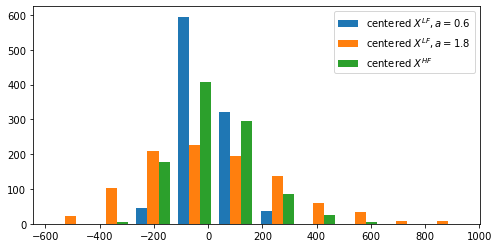

In [100]:
xi = sample_xi_p(1000)

xL = x_L(xi) 
xH = x_H(xi) 

a1 = 0.6
a2 = 1.8

xL_1 = a1*xH
xL_2 = a2*xH

plt.figure(figsize=(8,4))
plt.hist([xL_1-a1*ExH,xL_2-a2*ExH,xH-ExH],label=[r'centered $ X^{LF}, a=0.6$',r'centered $X^{LF}, a=1.8$',r'centered $X^{HF}$'])
plt.legend()
plt.savefig('tradeoff.pdf',format='pdf',dpi=200)

We evaluate the LF mean and HF mean using 1,000,000 simulated samples. 
The LF mean will be implemented in our algorithm, and the HF mean is only used for correctness check.

In [5]:
# evaluate LF and HF mean
xi  = sample_xi_p(int(1e6))
ExL = x_L(xi).mean()
ExH = x_H(xi).mean()

low_bound = torch.zeros(8)
low_bound[0],low_bound[1] = -1.94, -1.94
high_bound = torch.ones(8)
high_bound[0],high_bound[1] = 1.94, 1.94
bound      = torch.vstack((low_bound, high_bound)) # range of inputs

For computational convenience, we apply an NN for setting up an initial state for the Langevin algorithm.

100%|██████████| 500/500 [01:10<00:00,  7.09 Epoch/s, loss=0.005103672]   


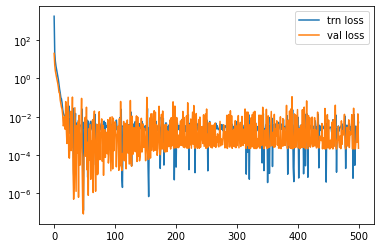

In [48]:
def loss(T, xi): # loss function for training the NN
    return torch.norm(x_L(T(xi)) - ExL).square()

input_size = 8 # the stochastic input dimension
low_bound = torch.zeros(8)
low_bound[0],low_bound[1] = -1.94, -1.94
high_bound = torch.ones(8)
high_bound[0],high_bound[1] = 1.94, 1.94
bound      = torch.vstack((low_bound, high_bound)) # range of inputs
T = NN(input_size,bound)

xi_trn = sample_xi_p(5000)
xi_val = sample_xi_p(1000)

trn_losses, val_losses = train_NN(T, xi_trn, loss, xi_val) # train the NN

plt.plot(trn_losses,label='trn loss')
plt.plot(val_losses,label='val loss')
plt.yscale('log')
plt.legend()

After training the NN for the initial state, we conduct the Langevin algorithm for sampling $q(\xi)$.

In [6]:
def score(xi, l): #score function, return grad q(xi)
    new_xi = xi.detach().clone()
    new_xi.requires_grad_(True)
    xL_xi = x_L(new_xi)
    xL_xi.backward(torch.ones(len(new_xi)))

    grad_xL = new_xi.grad.detach()
    return ((ExL - x_L(xi).detach())/(l**2) * grad_xL.T + 2*xi[:,0] + 2*xi[:,1]).T

def langevin(xi_init, iter_num, l, eta): # function for Langevin algorithm
    for s in range(iter_num):
        xi_new  = xi_init + eta * score(xi_init, l) + np.sqrt(2*eta)*torch.randn_like(xi_init)
        xi_init = xi_new.detach().clamp_(min=bound[0],max=bound[1])
    return xi_new

def sample_xi_q(N, 
                T, 
                l=1.0, 
                iter_num=int(1e2),
                eta=1e-4): # sample xi by q(x)
    xi_p    = sample_xi_p(N)
    xi_init = T(xi_p).detach()
    return langevin(xi_init,iter_num,l,eta)

def weight(xi,l): # evaluate the unnormalized weight for the given xi
    return ((x_L(xi) - ExL).square()/(2*l**2)).exp()

In [84]:
## conduct experiments for estimating ExH with regular MC and L-BF-IS
l    = 5.25 #np.maximum(float(MC_N) * 1.0, 100.0) 5.0 is the best value
MC_N_lst = (10**np.linspace(0, 2, 10)).astype('int')
MC = []
IS = []
num_trial = 100
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    for MC_N in MC_N_lst:
        # l    = np.maximum(float(MC_N) * 0.1, 5.0)
        xi_p = sample_xi_p(MC_N) # sample MC xi_p
        xi_q = sample_xi_q(MC_N,T,l,iter_num=int(1e4),eta=1e-4) # sample L-BF-IS xi_q
        wt_q = weight(xi_q,l) # compute L-BF-IS weights
        wt_q /= wt_q.sum().item()
        
        MC_est_lst.append(x_H(xi_p).mean().item())
        IS_est_lst.append((x_H(xi_q) * wt_q).sum())
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)
MC_mean = np.nanmean(MC, axis=0)
MC_std  = np.nanstd(MC, axis=0)
IS_mean = np.nanmean(IS, axis=0)
IS_std  = np.nanstd(IS, axis=0)

In [40]:
def potential(z,l): # evaluate the potential function for the given z
    return (x_L(z)-ExL)**2/(2*l**2) + z[:,0]**2 + z[:,1]**2

def unadjusted_langevin_algorithm(potential, iter_num=int(1e5), step=1e-7, l=1.0, burn_in=int(1e7)):
    Z0 = sample_xi_p(1)
    Zi = Z0
    samples = []
    for i in tqdm(range(iter_num + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi,l).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        rejected = True
        while rejected:
            new_Zi = Zi.detach() - step * l**2 * grad + np.sqrt(2 * step * l**2) * torch.randn(1, 8)
            if (new_Zi[:,2:] < 1).all() and (new_Zi[:,2:] > 0).all():
                Zi = new_Zi
                rejected = False
        samples.append(Zi.detach())
    return torch.cat(samples, 0)[burn_in:]

def weight(xi,l): # evaluate the unnormalized weight for the given xi
    wt = ((x_L(xi) - ExL).square()/(2*l**2)).exp()
    return wt

In [47]:
## conduct experiments for estimating ExH with regular MC and L-BF-IS
l    = 7.5 #np.maximum(float(MC_N) * 1.0, 100.0) 5.0 is the best value
iter_num = int(1e5)
burn_in = int(1e7)
step    = 1e-7
MC_N_lst = (10**np.linspace(0, 4, 10)).astype('int')
xi_q_lst = unadjusted_langevin_algorithm(potential,step=step,iter_num=iter_num,l=l,burn_in=burn_in)
MC = []
IS = []
num_trial = 100
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    for MC_N in MC_N_lst:
        xi_p     = sample_xi_p(MC_N) # sample MC xi_p
        xi_q = xi_q_lst[np.random.choice(iter_num,MC_N)]
        wt_q = weight(xi_q,l)
        wt_q /= wt_q.sum()
        MC_est_lst.append(x_H(xi_p).mean().item())
        IS_est_lst.append((wt_q*x_H(xi_q)).sum())
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)

MC      = np.array(MC)
IS      = np.array(IS)
MC_mean = np.nanmean(MC, axis=0)
MC_std  = np.nanstd(MC, axis=0)
IS_mean = np.nanmean(IS, axis=0)
IS_std  = np.nanstd(IS, axis=0)

In [48]:
MC_err = (np.array(MC) - ExH.item())**2
IS_err = (np.array(IS) - ExH.item())**2

MC_rmse  = np.sqrt(np.nanmean(MC_err, axis=0))
IS_rmse  = np.sqrt(np.nanmean(IS_err, axis=0))

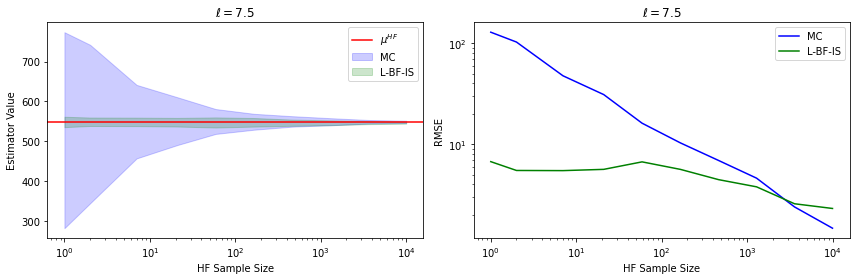

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

scale = 1.94

axs[0].fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='b',alpha=0.2,label='MC')
axs[0].fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='g',alpha=0.2,label='L-BF-IS')
axs[0].axhline(ExH,c='r',label=r'$\mu^{HF}$')
axs[0].set_xscale('log')
axs[0].set_xlabel('HF Sample Size')
axs[0].set_ylabel('Estimator Value')
axs[0].legend()
axs[0].set_title(r'$\ell=7.5$')

axs[1].plot(MC_N_lst, MC_rmse,color='b',alpha=1.0,label='MC')
axs[1].plot(MC_N_lst, IS_rmse,color='g',alpha=1.0,label='L-BF-IS')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('HF Sample Size')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].set_title(r'$\ell=7.5$')

fig.tight_layout()
plt.savefig('dim-8-l75.pdf',format='pdf',dpi=200)

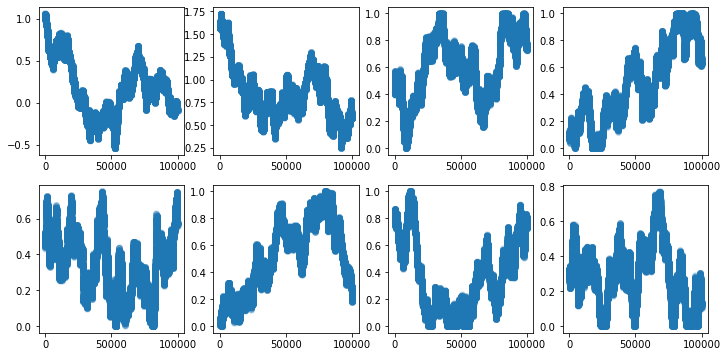

In [51]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(2):
    for j in range(4):
        axs[i,j].plot(xi_q_lst[:,j+4*i],'o',alpha=0.1)

In [52]:
# generate variance of same N but different l
l_lst = np.linspace(1.0, 20.0, 3)
iter_num_lst = [int(1e5)] * 3
burn_in_lst  = [int(1e7)] * 3
step_lst     = [1e-7] * 3

MC2 = []
IS2 = []

MC_N = 100
for l, iter_num, burn_in in zip(l_lst, iter_num_lst, burn_in_lst):
    step    = 1e-7
    MC_N_lst = (10**np.linspace(0, 4, 10)).astype('int')
    xi_q_lst = unadjusted_langevin_algorithm(potential,step=step,iter_num=iter_num,l=l,burn_in=burn_in)
    MC_est_lst = []
    IS_est_lst = []
    num_trial = 100
    for j in range(num_trial):
        xi_p     = sample_xi_p(MC_N) # sample MC xi_p
        xi_q = xi_q_lst[np.random.choice(iter_num,MC_N)]
        wt_q = weight(xi_q,l)
        wt_q /= wt_q.sum()
        MC_est_lst.append(x_H(xi_p).mean().item())
        IS_est_lst.append((wt_q*x_H(xi_q)).sum())

    MC2.append(MC_est_lst)
    IS2.append(IS_est_lst)

MC2     = np.array(MC2)
IS2     = np.array(IS2)
MC_mean = np.nanmean(MC2, axis=0)
MC_std  = np.nanstd(MC2, axis=0)
IS_mean = np.nanmean(IS2, axis=0)
IS_std  = np.nanstd(IS2, axis=0)

In [59]:
MC2     = np.array(MC2)
IS2     = np.array(IS2)
MC_mean = np.nanmean(MC2, axis=1)
MC_std  = np.nanstd(MC2, axis=1)
IS_mean = np.nanmean(IS2, axis=1)
IS_std  = np.nanstd(IS2, axis=1)

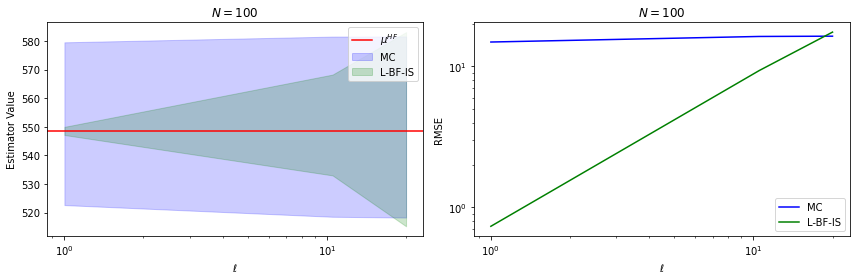

In [61]:
MC_err2 = (np.array(MC2) - ExH.item())**2
IS_err2 = (np.array(IS2) - ExH.item())**2

MC_rmse2  = np.sqrt(np.nanmean(MC_err2, axis=1))
IS_rmse2  = np.sqrt(np.nanmean(IS_err2, axis=1))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

scale = 1.94

axs[0].fill_between(l_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='b',alpha=0.2,label='MC')
axs[0].fill_between(l_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='g',alpha=0.2,label='L-BF-IS')
axs[0].axhline(ExH,c='r',label=r'$\mu^{HF}$')
axs[0].set_xscale('log')
axs[0].set_xlabel(r'$\ell$')
axs[0].set_ylabel('Estimator Value')
axs[0].legend()
axs[0].set_title(r'$N=100$')

axs[1].plot(l_lst, MC_rmse2,color='b',alpha=1.0,label='MC')
axs[1].plot(l_lst, IS_rmse2,color='g',alpha=1.0,label='L-BF-IS')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\ell$')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].set_title(r'$N=100$')

fig.tight_layout()

In [58]:
np.nanmean(MC2, axis=1).shape

(3,)